<h1> Simple neural Network

In [15]:
import myfunctions as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
def cut_clusters_bigger_than5(xMC, yMC):
    for i in range(len(xMC)):
        x = xMC[i]
        y = yMC[i]
        val_x, count_x = np.unique(x, return_counts=True)
        val_y, count_y = np.unique(y, return_counts=True)
        if (count_x.max()>5 or count_y.max()>5):
            print(i)

# fast fix:
ind_cut = np.array([40273, 40768, 170553, 182447, 223826, 228847, 295810, 328797, 419807, 438893, 496042, 502671, 508168, 570441, 622217, 646609])


Delecte all clusters that are bigger thatn 5x5! That's a problem for later on

In [6]:
xMC = np.delete(xMC, ind_cut, axis=0)
yMC = np.delete(yMC, ind_cut, axis=0)
EMC = np.delete(EMC, ind_cut, axis=0)
x_truth = np.delete(x_truth, ind_cut)
y_truth = np.delete(y_truth, ind_cut)
E_truth = np.delete(E_truth, ind_cut)
x_fit = np.delete(x_fit, ind_cut)
y_fit = np.delete(y_fit, ind_cut)
E_fit = np.delete(E_fit, ind_cut)

In [8]:
# devide into training and verification 
xMC_train = xMC[:round(len(E_truth)*0.8)]
xMC_veri = xMC[round(len(E_truth)*0.8):]

yMC_train = yMC[:round(len(E_truth)*0.8)]
yMC_veri = yMC[round(len(E_truth)*0.8):]

EMC_train = EMC[:round(len(E_truth)*0.8)]
EMC_veri = EMC[round(len(E_truth)*0.8):]

x_truth_train = x_truth[:round(len(E_truth)*0.8)]
x_truth_veri = x_truth[round(len(E_truth)*0.8):]

y_truth_train = y_truth[:round(len(E_truth)*0.8)]
y_truth_veri = y_truth[round(len(E_truth)*0.8):]

E_truth_train = E_truth[:round(len(E_truth)*0.8)]
E_truth_veri = E_truth[round(len(E_truth)*0.8):]

x_fit_veri = x_fit[round(len(E_truth)*0.8):]
y_fit_veri = y_fit[round(len(E_truth)*0.8):]
E_fit_veri = E_fit[round(len(E_truth)*0.8):]

In [9]:
clusters5x5, coord, x_edge, y_edge = mf.form_cluster(xMC_train, yMC_train, EMC_train)
clusters = clusters5x5.reshape((clusters5x5.shape[0], 25))
print(clusters.shape)

This took  226.34638595581055 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/myfunctions.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


(575162, 25)


In [10]:
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord)
print(training.shape) # (575162, 3)

(575162, 3)


<h2> Simple NN

In [30]:
model1 = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 3)                

In [31]:
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

In [32]:
fit_hist = model1.fit(clusters, training, batch_size=50, epochs=50, validation_split=0.1)

Epoch 1/50
10353/10353 [==============================] - 19s 2ms/step - loss: 20.5993 - val_loss: 2.8400
Epoch 2/50
10353/10353 [==============================] - 19s 2ms/step - loss: 1.7174 - val_loss: 2.3046
Epoch 3/50
10353/10353 [==============================] - 18s 2ms/step - loss: 0.6330 - val_loss: 0.3801
Epoch 4/50
10353/10353 [==============================] - 19s 2ms/step - loss: 0.3144 - val_loss: 0.2771
Epoch 5/50
10353/10353 [==============================] - 18s 2ms/step - loss: 0.2344 - val_loss: 0.1962
Epoch 6/50
10353/10353 [==============================] - 19s 2ms/step - loss: 0.2022 - val_loss: 0.1982
Epoch 7/50
10353/10353 [==============================] - 19s 2ms/step - loss: 0.1804 - val_loss: 0.1571
Epoch 8/50
10353/10353 [==============================] - 19s 2ms/step - loss: 0.1655 - val_loss: 0.1409
Epoch 9/50
10353/10353 [==============================] - 19s 2ms/step - loss: 0.1561 - val_loss: 0.1353
Epoch 10/50
10353/10353 [=============================

okay wie gut war das jetzt...?

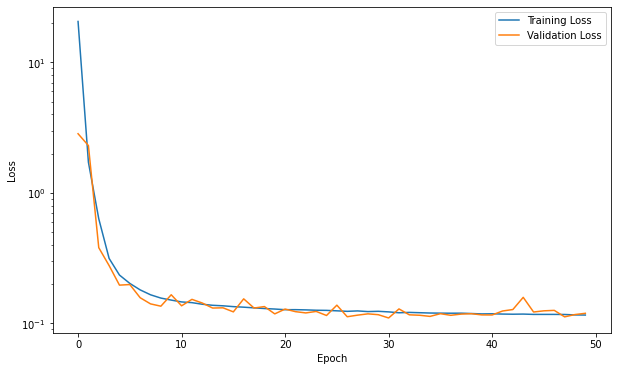

In [35]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"])
plt.yscale('log')
plt.show()

In [19]:
clusters5x5_v, coord_v, x_edge_v, y_edge_v = mf.form_cluster(xMC_veri, yMC_veri, EMC_veri)
clusters_v = clusters5x5_v.reshape((clusters5x5_v.shape[0], 25))

This took  56.76056098937988 s


In [33]:
output = model1.predict(clusters_v)

In [28]:
#keras.models.save_model(model1, 'stage1model')

INFO:tensorflow:Assets written to: stage1model/assets


<h2> Evaluation

In [21]:
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)

In [22]:
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

In [23]:
def histo_output(arr_NN, arr_fit, arr_truth, name=''):
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(2,1,1)
    plt.hist(arr_NN-arr_truth, bins=200)
    plt.title(name + " difference NN - truth")
    plt.yscale('log')
    
    plt.subplot(2,1,2)
    plt.hist(arr_fit-arr_truth, bins=200)
    plt.title(name + " difference fit - truth")
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

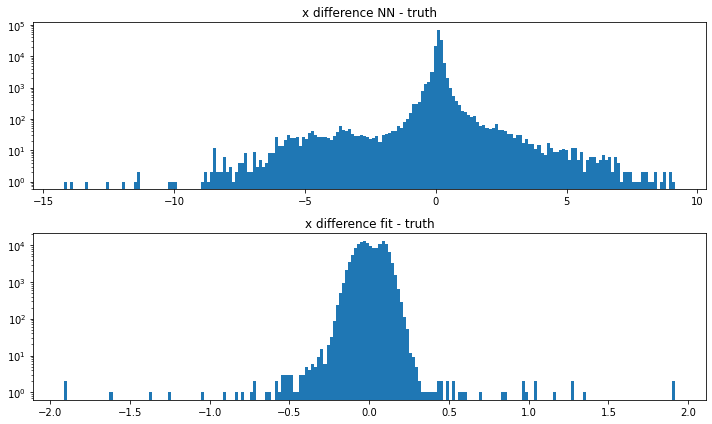

In [24]:
histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

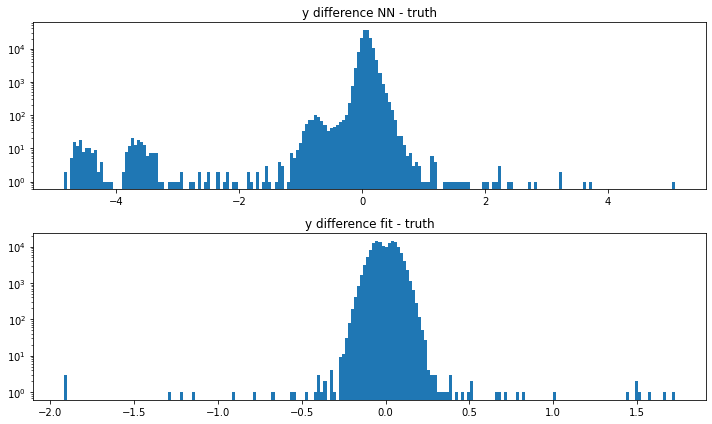

In [25]:
histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

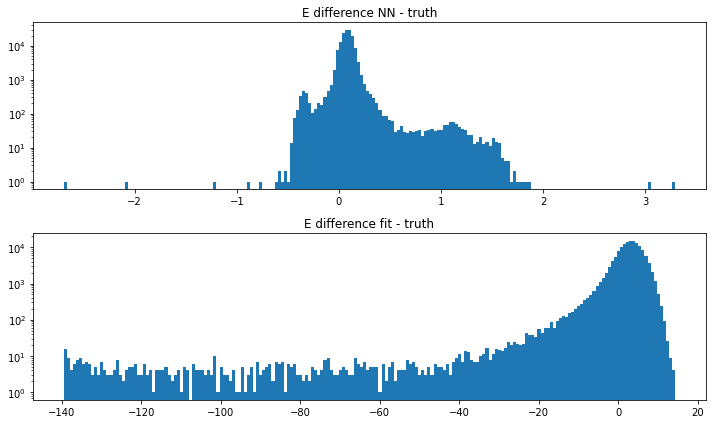

In [26]:
histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E")